<a href="https://colab.research.google.com/github/zcheng233/SF-crime-analysis-in-Apache-Spark/blob/main/theft_time_series_lstm_proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Setting Spark
!pip install pyspark

     |████████████████████████████████| 212.4 MB 78 kB/s 
     |████████████████████████████████| 198 kB 39.6 MB/s 
  Created wheel for pyspark: filename=pyspark-3.1.2-py2.py3-none-any.whl size=212880768 sha256=ce1000b729d7e85eabc032e88c26e6ce82af6a702b0e6ba6d971f2b1c77c97a0
  Stored in directory: /root/.cache/pip/wheels/a5/0a/c1/9561f6fecb759579a7d863dcd846daaa95f598744e71b02c77
Successfully built pyspark


In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local").getOrCreate()

In [ ]:
spark

In [ ]:
from pyspark.sql import Row 
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import torch.nn as nn
import torch
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import RandomizedSearchCV



# SF Crime Prediction RNN 

In this project, I perform a time series prediction using a Recurrent Neural Network regressor. For this example, I will predict **weekly theft crime rate** in San Francisco **7 weeks** in advance.

The particular network architecture I will employ for my RNN is a  [Long Term Short Memory (LTSM)](https://en.wikipedia.org/wiki/Long_short-term_memory), which helps significantly avoid technical problems with optimization of RNNs.

- Pytorch LSTM Time Series Predictor  
This is a Pytorch version of the original Keras LSTM Stock Predictor provided by [Super DataScience](https://www.superdatascience.com/deep-learning/).

## Step 1: Loading and preprocessing the data

First let's load in the SFPD crime incident report dataset from SFPD website. It contails incident reports of all categories of size ~551 MB from 2003 to 2018.  
We need to first turn it into time series - a history of **806 records of weekly theft incident counts**. This process is done with **Spark** because we are dealing with a large dataset. 

Then we need to perform a number of **pre-processing steps to prepare it for use with an RNN model**. In this process as well as all RNN training process later, I use numpy array because pytorch works perfectly well with numpy by its nature.

First off, it is good practice to **normalize time series** - by normalizing its range.  This helps us avoid serious numerical issues associated how common activation functions (like tanh) transform very large (positive or negative) numbers, as well as helping us to avoid related issues when computing derivatives.

Here we normalize the series to lie in the range [0,1] [using this scikit function](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html).

In [ ]:
# download the data from SF government website
#!wget -O sf_03_18.csv https://data.sfgov.org/api/views/tmnf-yvry/rows.csv?accessType=DOWNLOAD

In [ ]:
# mount your google drive 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# move downloaded data to google drive
#!mv -v sf_03_18.csv /content/drive/MyDrive/SFPD_data

In [ ]:
# load data from google drive into spark
data_path = '/content/drive/MyDrive/SFPD_data/sf_03_18.csv'
sf_crime = spark.read.format("csv")\
  .option("header", "true")\
  .option("interSchema", "true")\
  .load(data_path)

# feature engineering
sf_crime = sf_crime.withColumn('Date', to_date(sf_crime.Date, "MM/dd/yyyy"))
sf_crime = sf_crime.withColumn('Time', to_timestamp(sf_crime.Time, "HH:mm"))
sf_crime = sf_crime.withColumn('Hour', hour(sf_crime['Time']))
sf_crime = sf_crime.withColumn('WeekOfYear', weekofyear(sf_crime['Date']))
sf_crime = sf_crime.withColumn('Year', year(sf_crime['Date']))
sf_crime = sf_crime.withColumn('Month', month(sf_crime['Date']))

# select only needed columns
cols = ['IncidntNum', 'Category', 'Descript', 'DayOfWeek', 'Date', 'Time', 'Hour','WeekOfYear','Year','Month','PdDistrict','Resolution','X','Y','location']
sf_crime = sf_crime.select(cols)

# drop non-criminal incidents, since we are analyzing crime data only
sf_crime = sf_crime.select(cols).where(sf_crime.Category!='NON-CRIMINAL')

# create sql table
sf_crime.createOrReplaceTempView("sf_crime")
sf_crime.cache()
sf_crime.limit(5).show()

+----------+--------------+--------------------+---------+----------+-------------------+----+----------+----+-----+----------+----------+-----------------+----------------+--------------------+
|IncidntNum|      Category|            Descript|DayOfWeek|      Date|               Time|Hour|WeekOfYear|Year|Month|PdDistrict|Resolution|                X|               Y|            location|
+----------+--------------+--------------------+---------+----------+-------------------+----+----------+----+-----+----------+----------+-----------------+----------------+--------------------+
| 031147516| LARCENY/THEFT|PETTY THEFT FROM ...|   Sunday|2003-09-28|1970-01-01 10:00:00|  10|        39|2003|    9|  SOUTHERN|      NONE|           -120.5|              90|POINT (-120.50000...|
| 050697011|       ASSAULT|             BATTERY|Wednesday|2005-06-22|1970-01-01 12:20:00|  12|        25|2005|    6|  NORTHERN|      NONE|-122.428223303176|37.7818959488603|POINT (-122.42822...|
| 060747292|       ASSAUL

In [ ]:
# create time series data for training: weekly theft count
# predict weekly count of theft incidents
theft_week = sf_crime.where(sf_crime.Category=='LARCENY/THEFT').groupby(['Year','WeekOfYear']).count().orderBy(['Year','WeekOfYear']).withColumnRenamed('count','crime')
theft_week.withColumn('crime',theft_week['crime'].cast("float"))
theft_week.limit(5).show()

+----+----------+-----+
|Year|WeekOfYear|crime|
+----+----------+-----+
|2003|         1|  468|
|2003|         2|  440|
|2003|         3|  467|
|2003|         4|  516|
|2003|         5|  506|
+----+----------+-----+



In [ ]:
# Alternate: create time series data for training: daily theft count
# predict daily count of theft incidents
#theft_day = sf_crime.where(sf_crime.Category=='LARCENY/THEFT').groupby(['Date']).count().orderBy(['Date']).withColumnRenamed('count','crime')
#theft_day.withColumn('crime',theft_day['crime'].cast("float"))
#theft_day.limit(5).show()

In [ ]:
# Feature Scaling

sc = MinMaxScaler(feature_range = (0, 1))

# scale the data
data_array = np.array(theft_week.select("crime").collect())
data_array = sc.fit_transform(data_array)
len(data_array)

806

## Step 2:  Cutting our time series into sequences

Remember, our time series is a sequence of numbers that we can represent in general mathematically as 

$$s_{0},s_{1},s_{2},...,s_{P}$$

where $s_{p}$ is the numerical value of the time series at time period $p$ and where $P$ is the total length of the series.  In order to apply our RNN we treat the time series prediction problem as a regression problem, and so need to use a sliding window to construct a set of associated input/output pairs to regress on.  This process is animated in the gif below.

<img src="https://github.com/tonylaioffer/stock-prediction-lstm-using-keras/raw/master/images/timeseries_windowing_training.gif" width=600 height=288/>

For example - using a window of size T = 5 (as illustrated in the gif above) we produce a set of input/output pairs like the one shown in the table below

$$\begin{array}{c|c}
\text{Input} & \text{Output}\\
\hline \color{CornflowerBlue} {\langle s_{1},s_{2},s_{3},s_{4},s_{5}\rangle} & \color{Goldenrod}{ s_{6}} \\
\ \color{CornflowerBlue} {\langle s_{2},s_{3},s_{4},s_{5},s_{6} \rangle } & \color{Goldenrod} {s_{7} } \\
\color{CornflowerBlue}  {\vdots} & \color{Goldenrod} {\vdots}\\
\color{CornflowerBlue} { \langle s_{P-5},s_{P-4},s_{P-3},s_{P-2},s_{P-1} \rangle } & \color{Goldenrod} {s_{P}}
\end{array}$$

Notice here that each input is a sequence (or vector) of length 5 (and in general has length equal to the window size T) while each corresponding output is a scalar value.  Notice also how given a time series of length P and window size T = 5 as shown above, we created P - 5  input/output pairs.  More generally, for a window size T we create P - T such pairs.

Now let's window the input time series as described above! 

In [ ]:
#Create a function to process the scaled data into window T look back slices
def processData(data, lb):
    X, Y = [], []
    for i in range(len(data) - lb - 1):
        X.append(data[i: (i + lb), 0])
        Y.append(data[(i + lb), 0])
    return np.array(X), np.array(Y)


In [ ]:
X, y = processData(data_array, 7)
len(X)

798

## Step 3: Split training and testing sets

In order to perform proper testing on our dataset we will lop off the last 20% of it for validation (or testing).  

Note here we are **not** splitting the dataset *randomly* as one typically would do when validating a regression model.  This is because our input/output pairs *are related temporally*.   We don't want to validate our model by training on a random subset of the series and then testing on another random subset, as this simulates the scenario that we receive new points *within the timeframe of our training set*.  

We want to train on one solid chunk of the series (in our case, the first full 80% of it), and validate on a later chunk (the last 20%) as this simulates how we would predict *future* values of a time series.

In [ ]:
def splitData(X, y, ratio):
    X_train, X_test = X[:int(X.shape[0]*ratio)],X[int(X.shape[0]*ratio):]
    y_train, y_test = y[:int(y.shape[0]*ratio)],y[int(y.shape[0]*ratio):]
    print('Spliting dataset size: \n', 'X_train:', X_train.shape[0], '\n X_test:', X_test.shape[0],'\n y_train:', y_train.shape[0], '\n y_test', y_test.shape[0])
    
    # reshaping （sequence length, batch size, input_size)
    X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
    X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

    return X_train, X_test, y_train, y_test


In [ ]:
X_train, X_test, y_train, y_test = splitData(X, y, 0.8)

Spliting dataset size: 
 X_train: 638 
 X_test: 160 
 y_train: 638 
 y_test 160


## Step 4:  Build and run an RNN regression model

Having created input/output pairs out of our time series and cut this into training/testing sets, we can now begin setting up our RNN.  We use the pytorch library to quickly build a two hidden layer RNN of the following specifications:

- layer 1 uses a LSTM module with 32 hidden neurons 
- layer 2 uses a fully connected module with one unit
- the 'mean_squared_error' loss and 'Adam' optimizer should be used

Note 1:   the LSTM input_shape = (sequence_length, batch_size, input_dim), which = (dataset size, 1, window size) in this particular case.   
- Sequence is the sequence of time series data we want to analyze, so its length is just the training dataset size.  
- Batch_size will define when to output a result. Because we have preprocessed the time series data to form a feature consists of samples of look back window, and we will use this feature to predict an output, so we need an output for every input, that is to set batch size = 1.  
If we didn't process our data but predicting on original time series, we should select batch size = window size, so it will output a prediction for each batch of data.
- Input_dim is the size of the feature, which equals to window size in this case.

Note 2: when choosing number hidden units to start, I refer to some formula suggested by other researchers, such as [this formula](https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw/136542#136542):   
*You can usually prevent over-fitting if you keep your number of neurons below:*  
*𝑁ℎ = 𝑁𝑠 / (𝛼 * (𝑁𝑖 + 𝑁𝑜))*  
*𝑁𝑖 = number of input neurons.  
𝑁𝑜 = number of output neurons.  
𝑁𝑠 = number of samples in training data set.  
𝛼 = an arbitrary scaling factor (usually 2-10), with the larger the more general model.*  

Alternately, there are many other rule-of-thumb methods for determining the correct number of neurons to use in the hidden layers, such as the following:
1. The number of hidden neurons should be between the size of the input layer and the size of the output layer.
2. The number of hidden neurons should be 2/3 the size of the input layer, plus the size of the output layer.
3. The number of hidden neurons should be less than twice the size of the input layer.)


In [ ]:
class RNN(nn.Module):
    def __init__(self, i_size, h_size, n_layers, o_size, dropout=0.1, bidirectional=True):
        # constructor: declare all the layers want to use
        # instantiate all modules, access by the names given in here later
        super(RNN, self).__init__()
        self.num_directions = bidirectional+1 #D=2 if bidirectional=Ture o.w. 1
        self.n_layers = n_layers
        self.h_size = h_size

        self.lstm = nn.LSTM(
            input_size=i_size,
            hidden_size=h_size,
            num_layers=n_layers,
            dropout=dropout, # for regularization
            bidirectional=bidirectional
        )
        self.fc = nn.Linear(h_size, o_size)

    def forward(self, x, h_state): #feed input, hidden states
        # define network structure: how the model is going to be run from input to output
        lstm_out, hidden_state = self.lstm(x, h_state) #layer 1:lstm
        lstm_out = lstm_out.view(-1, self.num_directions, self.h_size) #reshape the tensor by (sequence length, batch size, hidden size)
        
        outs = self.fc(lstm_out) #layer 2: fully connected
        
        return outs, hidden_state
    

In [ ]:
# Globals
INPUT_SIZE = 7 # must be equal to window_size T: the number of expected features in the input x
OUTPUT_SIZE = 1 # as it only needs to output predicted theft count
HIDDEN_SIZE = 128 # the number of features in the hidden state h
NUM_LAYERS = 2 # Number of recurrent layers stacking together to form a stacked LSTM


# Hyper parameters

learning_rate = 0.001
num_epochs = 40

# instantiate model
model = RNN(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE, bidirectional=False)
model.cuda()

# define loss function: MSE
criterion = nn.MSELoss() 
# define optimizer: Adam
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# if hidden_state is None, pytorch will automatically initializes it to zeros
hidden_state = None

In [ ]:
model

RNN(
  (lstm): LSTM(7, 128, num_layers=2, dropout=0.1)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

In [ ]:
history = []
X_test_cuda = torch.tensor(X_test).float().cuda()
y_test_cuda = torch.tensor(y_test).float().cuda()

# we use all the training data in one batch
inputs_cuda = torch.tensor(X_train).float().cuda()
labels_cuda = torch.tensor(y_train).float().cuda()

for epoch in range(num_epochs):

    model.train()
    output, _ = model(inputs_cuda, hidden_state) 

    loss = criterion(output[:,0,:].view(-1), labels_cuda)
    optimizer.zero_grad()
    loss.backward()                     # back propagation
    optimizer.step()                    # update the parameters
    
    if epoch % 20 == 0:
        model.eval()
        test_output, _ = model(X_test_cuda, hidden_state)
        test_loss = criterion(test_output.view(-1), y_test_cuda)
        print('epoch {}, loss {}, eval loss {}'.format(epoch, loss.item(), test_loss.item()))
    #else:
        #print('epoch {}, loss {}'.format(epoch, loss.item()))
    history.append(loss.item())

epoch 0, loss 0.23121091723442078, eval loss 0.4431537091732025
epoch 20, loss 0.011098741553723812, eval loss 0.05902343988418579
epoch 40, loss 0.006598154082894325, eval loss 0.03776765614748001
epoch 60, loss 0.0042077647522091866, eval loss 0.014428200200200081
epoch 80, loss 0.0036043880973011255, eval loss 0.016616148874163628


In [ ]:
#model.fc.weight 

In [ ]:
#for param in model.parameters():
#    print(param.data)

## Step 5: Checking model performance

With our model fit we can now make predictions on both our training and testing sets.

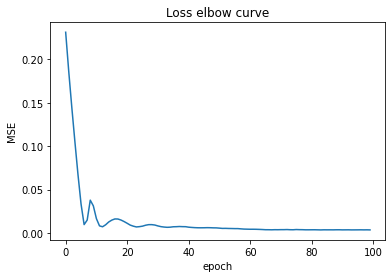

In [ ]:
# check if number of epoch is enough
plt.plot(history)
plt.title('Loss elbow curve')
plt.xlabel('epoch')
plt.ylabel('MSE')
plt.show()

In [ ]:
model.eval()
# test_inputs = torch.tensor(X_test).float().cuda()
test_predict, _ = model(X_test_cuda, hidden_state)
test_predict_cpu = test_predict.cpu().detach().numpy()

test_loss = criterion(test_predict.view(-1), y_test_cuda)
print("Test loss: {:.3f}".format(test_loss))
correct = np.squeeze(test_predict_cpu)
test_acc = np.sum(correct)/len(X_test_cuda)
print("Test accuracy: {:.3f}%".format(test_acc*100))

Test loss: 0.016
Test accuracy: 74.722%


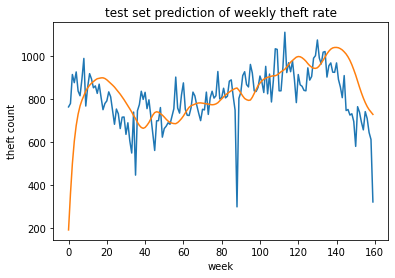

In [ ]:
# test sequence performance 
plt.plot(sc.inverse_transform(y_test.reshape(-1,1)))
plt.plot(sc.inverse_transform(test_predict_cpu.reshape(-1,1)))
plt.title('test set prediction of weekly theft rate')
plt.xlabel('week')
plt.ylabel('theft count')
plt.show()

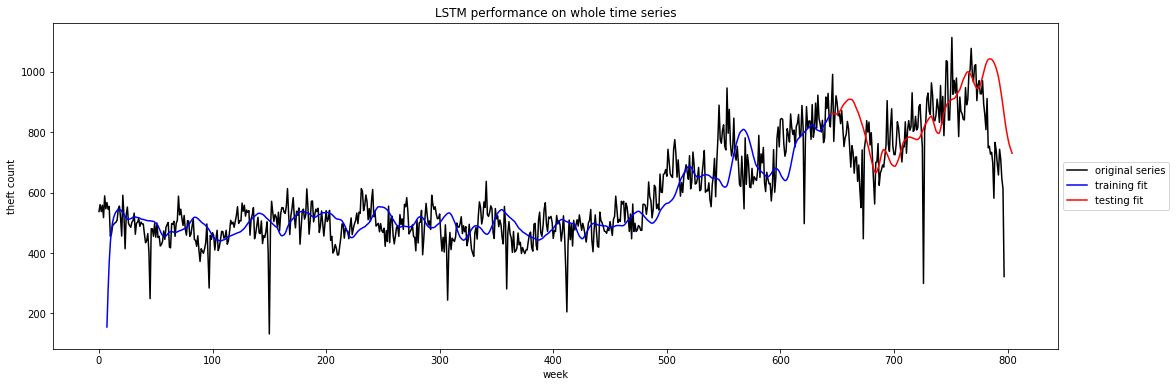

In [ ]:
#plot whole time series performance
fig=plt.figure(figsize=(18,6))
# plot original data
plt.plot(sc.inverse_transform(y.reshape(-1,1)), color='k')

# train_inputs = torch.tensor(X_train).float().cuda()
train_pred, hidden_state = model(inputs_cuda, None)
train_pred_cpu = train_pred.cpu().detach().numpy()

# use hidden state from previous training data
test_predict, _ = model(X_test_cuda, hidden_state)
test_predict_cpu = test_predict.cpu().detach().numpy()

# plt.plot(scl.inverse_transform(y_test.reshape(-1,1)))
split_pt = int(X.shape[0] * 0.8) + 7 # window_size
plt.plot(np.arange(7, split_pt, 1), sc.inverse_transform(train_pred_cpu.reshape(-1,1)), color='b')
plt.plot(np.arange(split_pt, split_pt + len(test_predict_cpu), 1), sc.inverse_transform(test_predict_cpu.reshape(-1,1)), color='r')


plt.title('LSTM performance on whole time series')
plt.xlabel('week')
plt.ylabel('theft count')
plt.legend(['original series','training fit','testing fit'], loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

## Further Analysis
It seems that the LSTM works fine with my manually tuned best set of parameters: HIDDEN_SIZE = 128, NUM_LAYERS = 2, learning_rate = 0.001, num_epochs = 40. 

However, it was not impressive if compared to the baseline Linear regression (see below).

Although there might be better performance if we further tune the RNN by random search/grid search, I think there is problem lies in the nature of time series data. A very similar performance of a simple linear model may implies that the time series we try to predict doesn't contain much more information to be derived.  

Remember DL methods are supposed to deal with complex data problems with underlying pattern that traditional methods cannot find or handle (such as NLP, text prediction). Time series data has many well-developed methods for analyze, such as ARIMA, detrending, etc., which has all been proved to be efficient enough in various problems.  

So time series analysis might not be a popular implementation for LSTM, and LSTM will have much more power in other suitable cases.  

In [ ]:
# fit a baseline Linear model
reg = LinearRegression().fit(X_train.squeeze(), y_train.squeeze())
y_pred = reg.predict(X_test.squeeze())
test_loss = mean_squared_error(y_test.squeeze(), y_pred)
print("Test loss: {:.3f}".format(test_loss))
test_acc = np.sum(y_pred)/len(X_test)
print("Test accuracy: {:.3f}%".format(test_acc*100))

Test loss: 0.007
Test accuracy: 72.372%


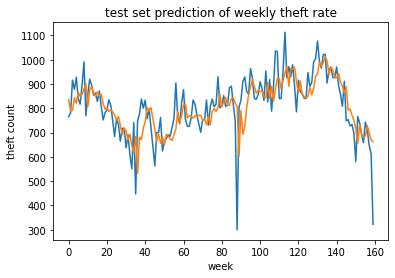

In [ ]:
plt.plot(sc.inverse_transform(y_test.reshape(-1,1)))
plt.plot(sc.inverse_transform(y_pred.reshape(-1,1)))
plt.title('test set prediction of weekly theft rate')
plt.xlabel('week')
plt.ylabel('theft count')
plt.show()